In [ ]:
# Basic Libraries
import math
import numpy as np
import pandas as pd
import seaborn as sb
import requests
import matplotlib.pyplot as plt # we only need pyplot

!pip install yfinance #insall yfinance API
!pip install tensorflow #install tensorflow API


#from alpha_vantage.timeseries import TimeSeries
import yfinance as yf
from pandas.tseries.offsets import BDay
sb.set() # set the default Seaborn style for graphics

import tensorflow as tf
from tensorflow import keras
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data


## Our Problem Statement 
---
Our aim is to find out the correlation between various stock prices with respect to Covid-19 situation in Singapore. Furthermore, we tried to predict future stock trend using machine learning. Hence, we would be able to compare Singapore companies stock prices as it is more closely related to the Covid cases in Singapore.

## Collecting dataset for Covid-19 

In [ ]:
covid = pd.read_csv('covid19_sg.csv')
# data is collected from Kaggle
covid.head(717)

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination,Sinovac vaccine doses,Cumulative individuals using Sinovac vaccine,Doses of other vaccines recognised by WHO,Cumulative individuals using other vaccines recognised by WHO,Number taken booster shots,Perc population taken booster shots
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,2022-01-04,842,0.0,281596,271,0,276936,3669,151,3,...,NaN,NaN,88%,87%,NaN,NaN,NaN,NaN,NaN,42%
713,2022-01-05,805,0.0,282401,453,0,277389,4015,155,2,...,NaN,NaN,88%,87%,NaN,NaN,NaN,NaN,NaN,43%
714,2022-01-06,813,0.0,283214,392,0,277781,4449,141,1,...,NaN,NaN,88%,87%,NaN,NaN,NaN,NaN,NaN,44%
715,2022-01-07,777,0.0,283991,338,0,278119,4892,135,2,...,NaN,NaN,89%,87%,NaN,NaN,NaN,NaN,NaN,44%


We are only concerned about daily confirmed cases as we can use the daily cases to compare with the daily closed of stock prices in Singapore. Thus, we are going to clean up the data to show only the daily confirmed cases.

In [ ]:
covid = pd.DataFrame(covid[['Date','Daily Confirmed']])
covid.head(717)

,Date,Daily Confirmed
0,2020-01-23,1
1,2020-01-24,2
2,2020-01-25,1
3,2020-01-26,0
4,2020-01-27,1
...,...,...
712,2022-01-04,842
713,2022-01-05,805
714,2022-01-06,813
715,2022-01-07,777


In [ ]:
covid.describe()

,Daily Confirmed
count,717.000000
mean,397.324965
std,823.667874
min,0.000000
25%,13.000000
50%,40.000000
75%,339.000000
max,5324.000000


In [ ]:
covid.Date = pd.to_datetime(covid.Date)

,Date,Daily Confirmed
0,2020-01-23,1
1,2020-01-24,2
2,2020-01-25,1
3,2020-01-26,0
4,2020-01-27,1
...,...,...
712,2022-01-04,842
713,2022-01-05,805
714,2022-01-06,813
715,2022-01-07,777


In [ ]:
covid = covid[(covid['Date'] >= '2020-4-01') & (covid['Date'] <= '2022-1-08')]

In [ ]:
covid

,Date,Daily Confirmed
69,2020-04-01,74
70,2020-04-02,49
71,2020-04-03,65
72,2020-04-04,75
73,2020-04-05,120
...,...,...
712,2022-01-04,842
713,2022-01-05,805
714,2022-01-06,813
715,2022-01-07,777


As the confirmed Covid cases data also include the weekends but the Singapore Exchange stock market is closed on weekends and public holidays.Thus, we have decided to further clean the data to exclude weekends namely Saturdays and Sundays and official public holidays.

In [ ]:
publichols = pd.read_csv('PublicHols2020-2022.csv')
publicholsdates = pd.DataFrame(publichols['Date'])
publicholsdates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    35 non-null     object
dtypes: object(1)
memory usage: 408.0+ bytes


In [ ]:
publicholsdates.Date = pd.to_datetime(publicholsdates.Date)
publicholsdates

,Date
0,2020-01-01
1,2020-01-27
2,2020-04-10
3,2020-05-01
4,2020-05-07
5,2020-05-25
6,2020-07-10
7,2020-07-31
8,2020-08-09
9,2020-08-10


In [ ]:
dates = []
for i in publicholsdates.Date:
    for j in covid.Date:
        if i==j:
            covid = covid[covid.Date != i]
            break

In [ ]:
isBusinessDay = BDay().onOffset
match_series = pd.to_datetime(covid['Date']).map(isBusinessDay)
covid = covid[match_series]

/usr/local/lib/python3.7/dist-packages/pandas/core/base.py:870: FutureWarning: onOffset is a deprecated, use is_on_offset instead
  new_values = map_f(values, mapper)


In [ ]:
covid

,Date,Daily Confirmed
69,2020-04-01,74
70,2020-04-02,49
71,2020-04-03,65
74,2020-04-06,66
75,2020-04-07,106
...,...,...
711,2022-01-03,464
712,2022-01-04,842
713,2022-01-05,805
714,2022-01-06,813


In [ ]:
covid = covid.reset_index(drop=True)

In [ ]:
covid = covid.rename(columns={'Daily Confirmed': 'dailyConfirmed'})
covid.head(717)

,Date,dailyConfirmed
0,2020-04-01,74
1,2020-04-02,49
2,2020-04-03,65
3,2020-04-06,66
4,2020-04-07,106
...,...,...
442,2022-01-03,464
443,2022-01-04,842
444,2022-01-05,805
445,2022-01-06,813



## Collecting datasets from Yahoo Finance (Yfinance)

Companies to explore: .<br><br>
We looked into companies from various industries which include:
1. Aviation
2. Pharmaceutical
3. Transport
4. Telecommunication
5. Information Technology 
6. Overall stock market in Singapore

### Singapore Airlines (SIA Stock)

Before retrieving our stock dataset, we obtained our API key from Alpha Vantage.
<br>From here, we retrieved the dataset for the stock we wished to explore using the API key.

In [ ]:
sia = yf.Ticker('C6L.SI')
sia_historical = sia.history(start="2020-04-01", end="2022-01-08", interval="1d")
sia_historical.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-04-01,4.016041,4.044224,3.875127,3.917402,5681347,0,0
2020-04-02,3.910356,4.001950,3.853990,3.980813,5765654,0,0
2020-04-03,3.959676,3.973767,3.875127,3.875127,4421002,0,0
2020-04-06,3.903310,4.072407,3.896264,4.051270,4741340,0,0
2020-04-07,4.086498,4.248549,4.058315,4.248549,5478812,0,0


In [ ]:
sia_historical.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 447 entries, 2020-04-01 to 2022-01-07
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          447 non-null    float64
 1   High          447 non-null    float64
 2   Low           447 non-null    float64
 3   Close         447 non-null    float64
 4   Volume        447 non-null    int64  
 5   Dividends     447 non-null    int64  
 6   Stock Splits  447 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 27.9 KB


We extracted only the daily close prices as we want to find out if covid cases in Singapore affects stock prices during the day. The daily closes of weekend stock market prices are not included in the data set as the market is closed during weekends.

In [ ]:
sia_close = pd.DataFrame(sia_historical['Close'])
sia_close = sia_close.reset_index()
sia_close.head(505)

,Date,Close
0,2020-04-01,3.917402
1,2020-04-02,3.980813
2,2020-04-03,3.875127
3,2020-04-06,4.051270
4,2020-04-07,4.248549
...,...,...
442,2022-01-03,5.010000
443,2022-01-04,5.060000
444,2022-01-05,5.030000
445,2022-01-06,5.010000


We extracted only the daily close prices as we wished to find out if covid cases will affect stock prices during the day.

### Biolidics Limited (Pharmaceutical)


In [ ]:
biolidics = yf.Ticker('8YY.SI')
biolidics_historical = biolidics.history(start="2020-04-01", end="2022-01-08", interval="1d")
biolidics_historical.head()
biolidics_close = pd.DataFrame(biolidics_historical['Close'])
biolidics_close = biolidics_close.reset_index()
biolidics_close.head(505)

,Date,Close
0,2020-04-01,0.265
1,2020-04-02,0.275
2,2020-04-03,0.255
3,2020-04-06,0.270
4,2020-04-07,0.270
...,...,...
442,2022-01-03,0.186
443,2022-01-04,0.181
444,2022-01-05,0.180
445,2022-01-06,0.175


### ComfortDelgro Corp (Transportation)

In [ ]:
comfortdel = yf.Ticker('C52.SI')
comfortdel_historical = comfortdel.history(start="2020-04-01", end="2022-01-08", interval="1d")
comfortdel_historical.head()
comfortdel_close = pd.DataFrame(comfortdel_historical['Close'])
comfortdel_close = comfortdel_close.reset_index()
comfortdel_close.head(505)

,Date,Close
0,2020-04-01,1.341287
1,2020-04-02,1.341287
2,2020-04-03,1.304790
3,2020-04-06,1.286541
4,2020-04-07,1.386909
...,...,...
442,2022-01-03,1.390000
443,2022-01-04,1.400000
444,2022-01-05,1.390000
445,2022-01-06,1.390000


### Singtel Telecommunications Limited (Telecommunication)

In [ ]:
singtel = yf.Ticker('Z74.SI')
singtel_historical = singtel.history(start="2020-04-01", end="2022-01-08", interval="1d")
singtel_historical.head()
singtel_close = pd.DataFrame(singtel_historical['Close'])
singtel_close = singtel_close.reset_index()
singtel_close.head(505)

,Date,Close
0,2020-04-01,2.343541
1,2020-04-02,2.436538
2,2020-04-03,2.399339
3,2020-04-06,2.427239
4,2020-04-07,2.483037
...,...,...
442,2022-01-03,2.330000
443,2022-01-04,2.340000
444,2022-01-05,2.320000
445,2022-01-06,2.340000


### Creative Technologies (Tech Industry)

In [ ]:
creative = yf.Ticker('C76.SI')
creative_historical = creative.history(start="2020-04-01", end="2022-01-08", interval="1d")
creative_historical.head()
creative_close = pd.DataFrame(creative_historical['Close'])
creative_close = creative_close.reset_index()
creative_close.head(505)

,Date,Close
0,2020-04-01,1.66
1,2020-04-02,1.64
2,2020-04-03,1.60
3,2020-04-06,1.67
4,2020-04-07,1.83
...,...,...
442,2022-01-03,2.34
443,2022-01-04,2.42
444,2022-01-05,2.39
445,2022-01-06,2.36


### Overall Stock Market in Singapore

In [ ]:
sti = yf.Ticker('^STI')
sti_historical = sti.history(start="2020-04-01", end="2022-01-08", interval="1d")
sti_historical.head()
sti_close = pd.DataFrame(sti_historical['Close'])
sti_close = sti_close.reset_index()
sti_close.head(505)

,Date,Close
0,2020-04-01,2440.270020
1,2020-04-02,2453.030029
2,2020-04-03,2389.290039
3,2020-04-06,2470.590088
4,2020-04-07,2571.889893
...,...,...
442,2022-01-03,3134.250000
443,2022-01-04,3181.129883
444,2022-01-05,3163.439941
445,2022-01-06,3184.300049


---

## Exploratory Analysis

In this subsection, we explore the data using boxplots, histograms and violin plots. These are basic uni-variate figures for each stock, and Covid 19 cases.
<br>Another analysis we did is by using bi-variate analysis between Covid 19 cases and each stock price to see their relationship.
<br>We also learnt how to plot 2 timeseries data on the same graph using twin axes, labelling and header.

### Positive increase (Covid 19 Cases)

In [ ]:
testing = pd.DataFrame(covid["dailyConfirmed"])

Q1 = testing.quantile(0.25)
Q3 = testing.quantile(0.75)
IQR = Q3 - Q1

cleantest = testing[~((testing < (Q1 - 1.5 * IQR)) |(testing > (Q3 + 1.5 * IQR))).any(axis=1)]
cleantest.head(500)

,dailyConfirmed
0,74
1,49
2,65
3,66
4,106
...,...
442,464
443,842
444,805
445,813


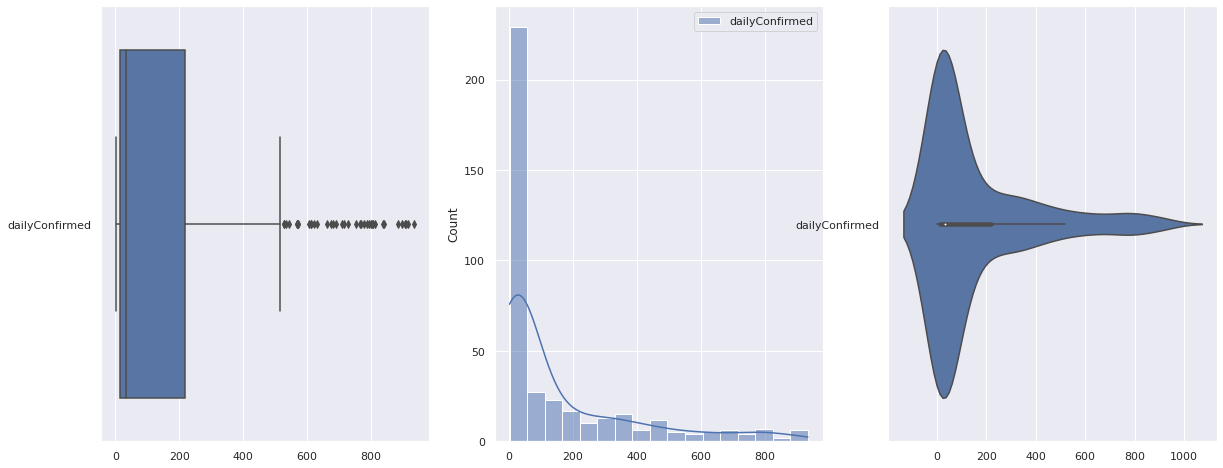

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 8))

sb.boxplot(data = cleantest, orient = "h", ax = axes[0])
sb.histplot(data = cleantest, kde = True, ax = axes[1])
sb.violinplot(data = cleantest, orient = "h", ax = axes[2])

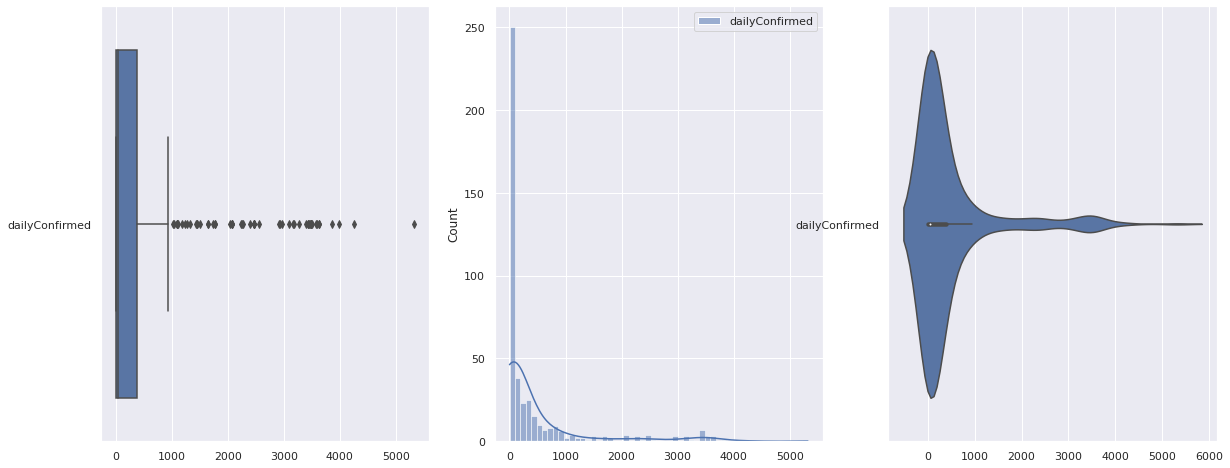

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 8))

sb.boxplot(data = covid, orient = "h", ax = axes[0])
sb.histplot(data = covid, kde = True, ax = axes[1])
sb.violinplot(data = covid, orient = "h", ax = axes[2])

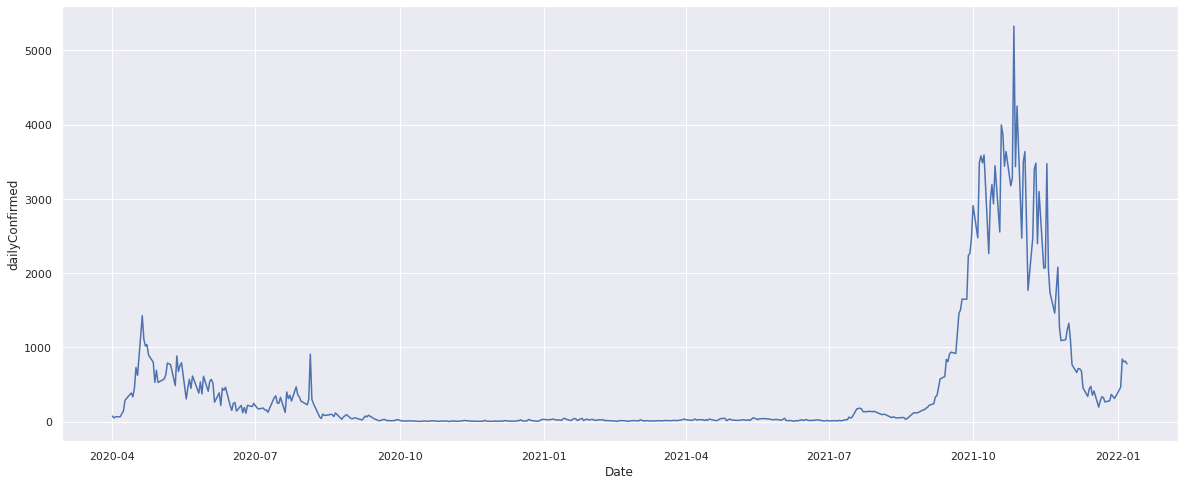

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(20, 8))
sb.lineplot(data=covid, x="Date", y="dailyConfirmed")

### Singapore Airlines Daily Close

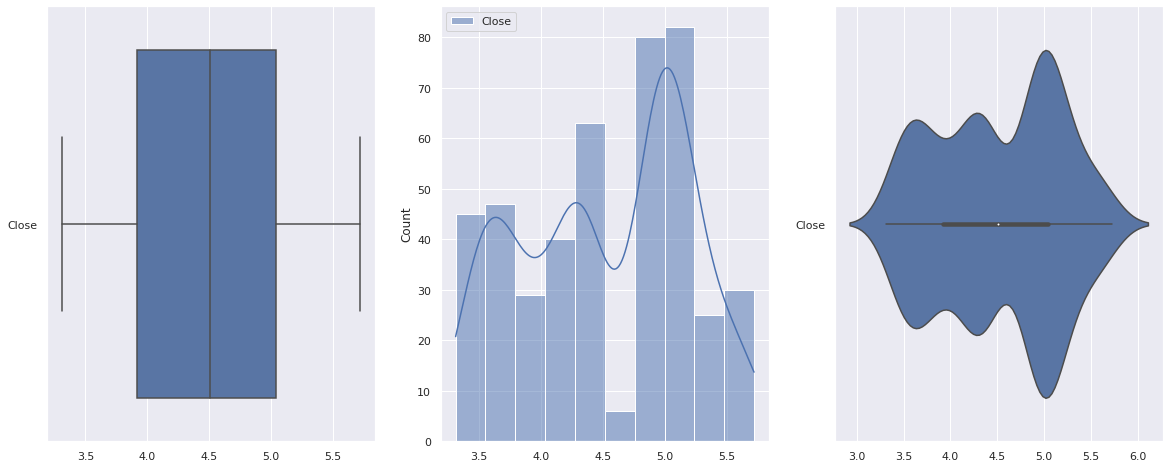

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 8))

sb.boxplot(data = sia_close, orient = "h", ax = axes[0])
sb.histplot(data = sia_close, kde = True, ax = axes[1])
sb.violinplot(data = sia_close, orient = "h", ax = axes[2])

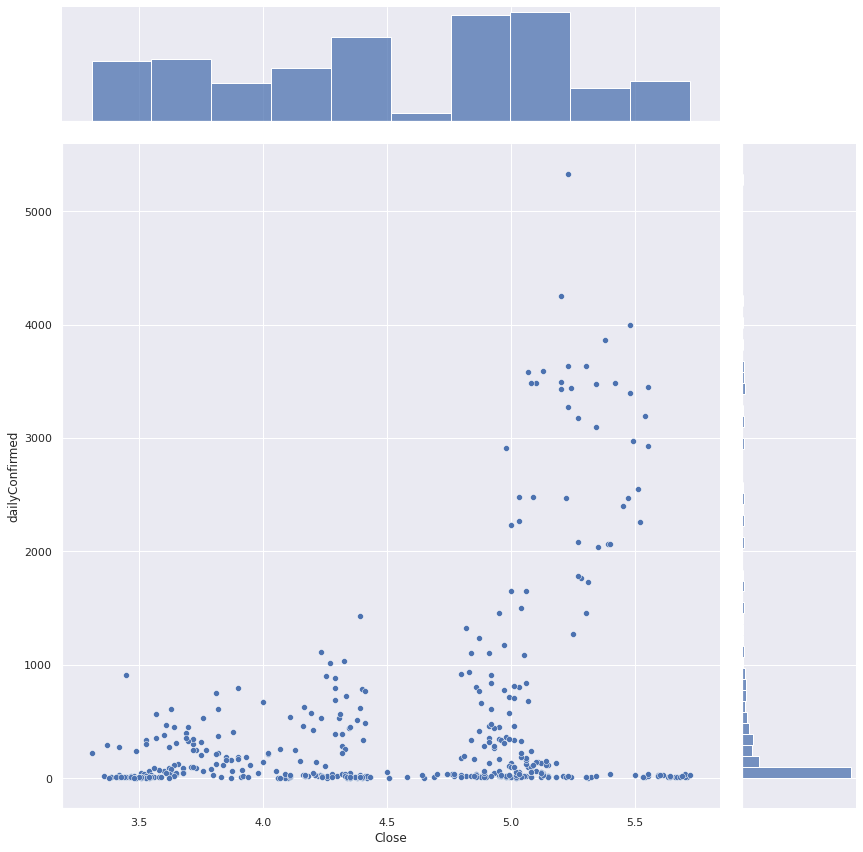

In [ ]:
# Create a joint dataframe by concatenating the two variables
covidsia = pd.concat([covid, sia_close], axis = 1).reindex(covid.index)
covidsia.info
sb.jointplot(data = covidsia, x = "Close", y = "dailyConfirmed", height = 12)
# covidsia

In [ ]:
covidsia.head(717)

,Date,dailyConfirmed,Date,Close
0,2020-04-01,74,2020-04-01,3.917402
1,2020-04-02,49,2020-04-02,3.980813
2,2020-04-03,65,2020-04-03,3.875127
3,2020-04-06,66,2020-04-06,4.051270
4,2020-04-07,106,2020-04-07,4.248549
...,...,...,...,...
442,2022-01-03,464,2022-01-03,5.010000
443,2022-01-04,842,2022-01-04,5.060000
444,2022-01-05,805,2022-01-05,5.030000
445,2022-01-06,813,2022-01-06,5.010000


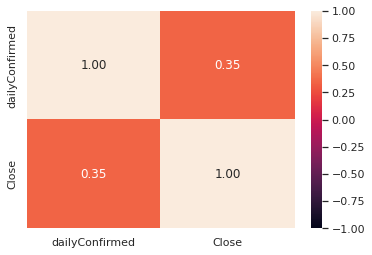

In [ ]:
sb.heatmap(covidsia.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

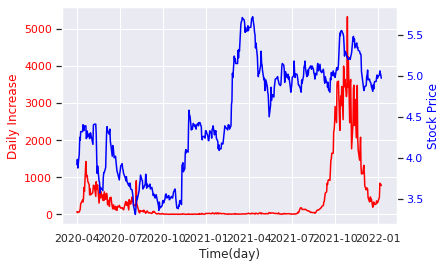

<Figure size 75x75 with 0 Axes>

In [ ]:
#covid.index = pd.to_datetime(covid.index)
#sia_close.date = pd.to_datetime(sia_close.date)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Time(day)")
ax1.set_ylabel("Daily Increase", color = 'red')
ax1.plot(covid.Date, covid.dailyConfirmed, color='red')
ax1.tick_params(axis='y', labelcolor = 'red')
ax2 = ax1.twinx()
ax2.set_ylabel("Stock Price", color = 'blue')
ax2.plot(sia_close.Date, sia_close.Close, color='blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.grid(False)
plt.figure(figsize=(0.5,0.5), dpi=150)
plt.show()

 Since data for correlation is 0.35, its moderately closely related. 

###Biolidics Limited Daily Close

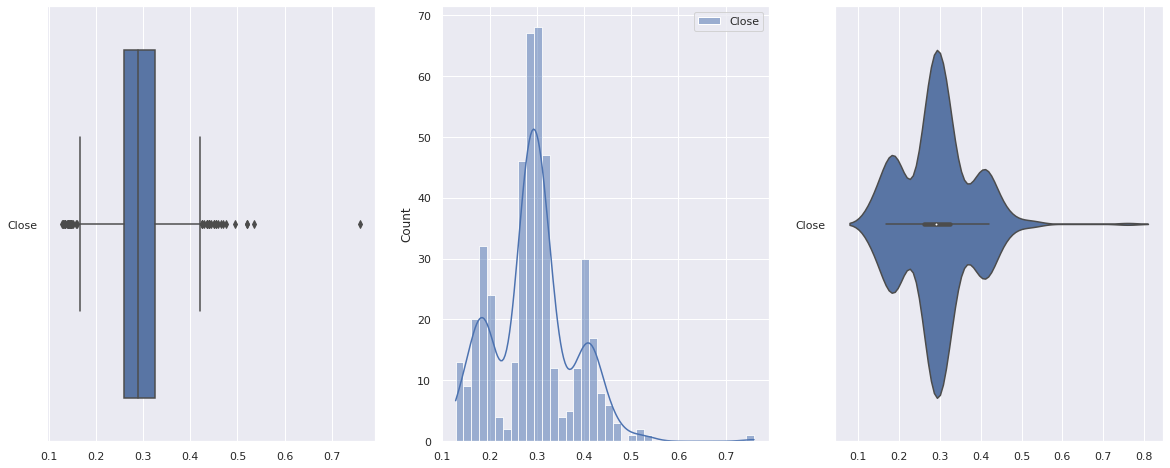

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 8))

sb.boxplot(data = biolidics_close, orient = "h", ax = axes[0])
sb.histplot(data = biolidics_close, kde = True, ax = axes[1])
sb.violinplot(data = biolidics_close, orient = "h", ax = axes[2])

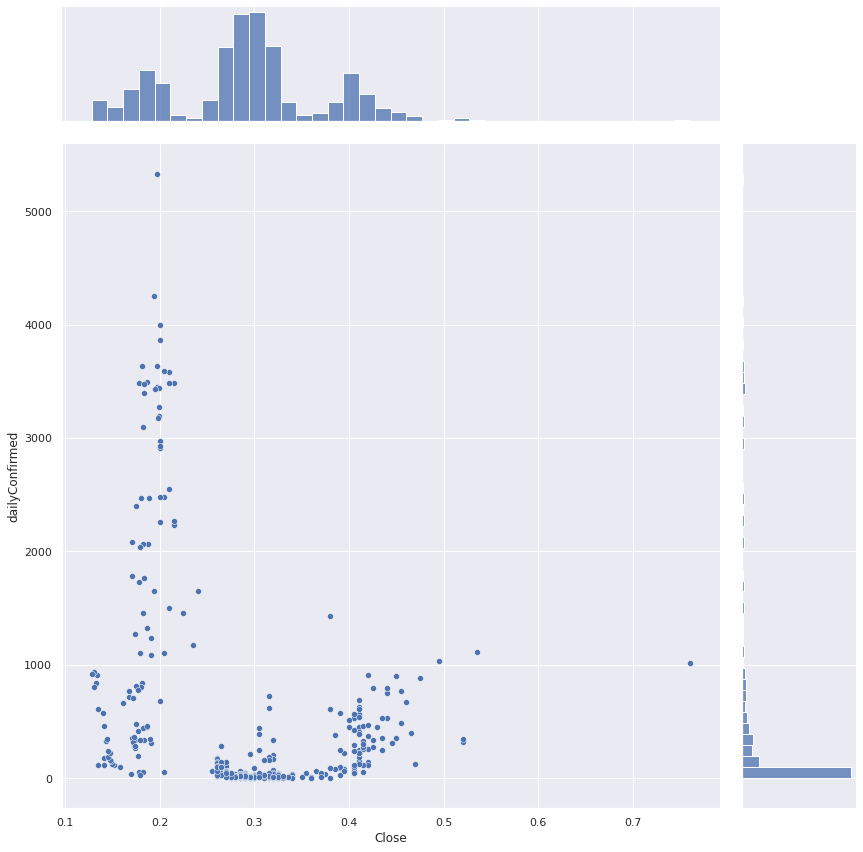

In [ ]:
# Create a joint dataframe by concatenating the two variables
covidbiolidics = pd.concat([covid, biolidics_close], axis = 1).reindex(covid.index)

sb.jointplot(data = covidbiolidics, x = "Close", y = "dailyConfirmed", height = 12)
# covidbiolidics

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(covidbiolidics)

          Date  dailyConfirmed       Date  Close
0   2020-04-01              74 2020-04-01  0.265
1   2020-04-02              49 2020-04-02  0.275
2   2020-04-03              65 2020-04-03  0.255
3   2020-04-06              66 2020-04-06  0.270
4   2020-04-07             106 2020-04-07  0.270
5   2020-04-08             142 2020-04-08  0.270
6   2020-04-09             287 2020-04-09  0.265
7   2020-04-13             386 2020-04-13  0.305
8   2020-04-14             334 2020-04-14  0.320
9   2020-04-15             447 2020-04-15  0.305
10  2020-04-16             728 2020-04-16  0.315
11  2020-04-17             623 2020-04-17  0.315
12  2020-04-20            1426 2020-04-20  0.380
13  2020-04-21            1111 2020-04-21  0.535
14  2020-04-22            1016 2020-04-22  0.760
15  2020-04-23            1037 2020-04-23  0.495
16  2020-04-24             897 2020-04-24  0.450
17  2020-04-27             799 2020-04-27  0.425
18  2020-04-28             528 2020-04-28  0.440
19  2020-04-29      

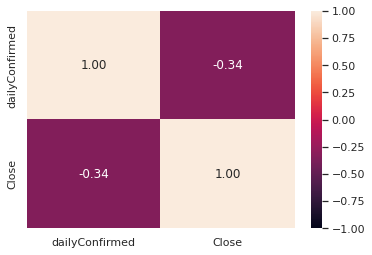

In [ ]:
sb.heatmap(covidbiolidics.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

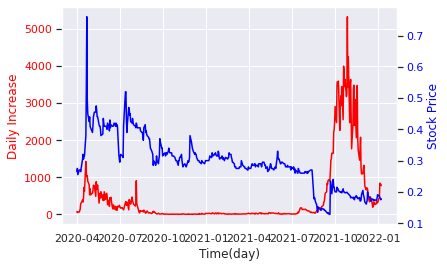

<Figure size 75x75 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Time(day)")
ax1.set_ylabel("Daily Increase", color = 'red')
ax1.plot(covid.Date, covid.dailyConfirmed, color='red')
ax1.tick_params(axis='y', labelcolor = 'red')
ax2 = ax1.twinx()
ax2.set_ylabel("Stock Price", color = 'blue')
ax2.plot(biolidics_close.Date, biolidics_close.Close, color='blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.grid(False)
plt.figure(figsize=(0.5,0.5), dpi=150)
plt.show()

 Since data for correlation is -0.34, its moderately closely related. 

### ComfortDelgro Corp, Inc Daily Close

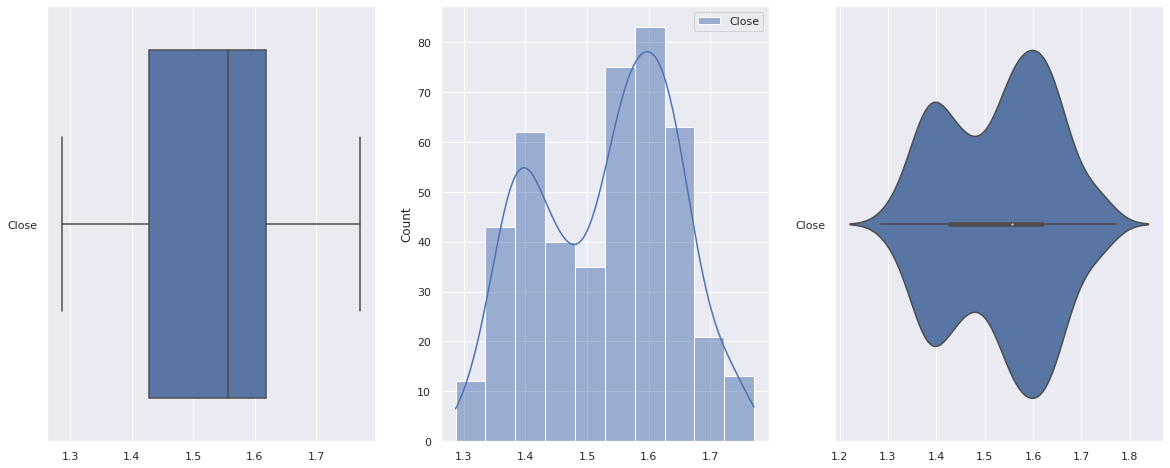

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 8))

sb.boxplot(data = comfortdel_close, orient = "h", ax = axes[0])
sb.histplot(data = comfortdel_close, kde = True, ax = axes[1])
sb.violinplot(data = comfortdel_close, orient = "h", ax = axes[2])

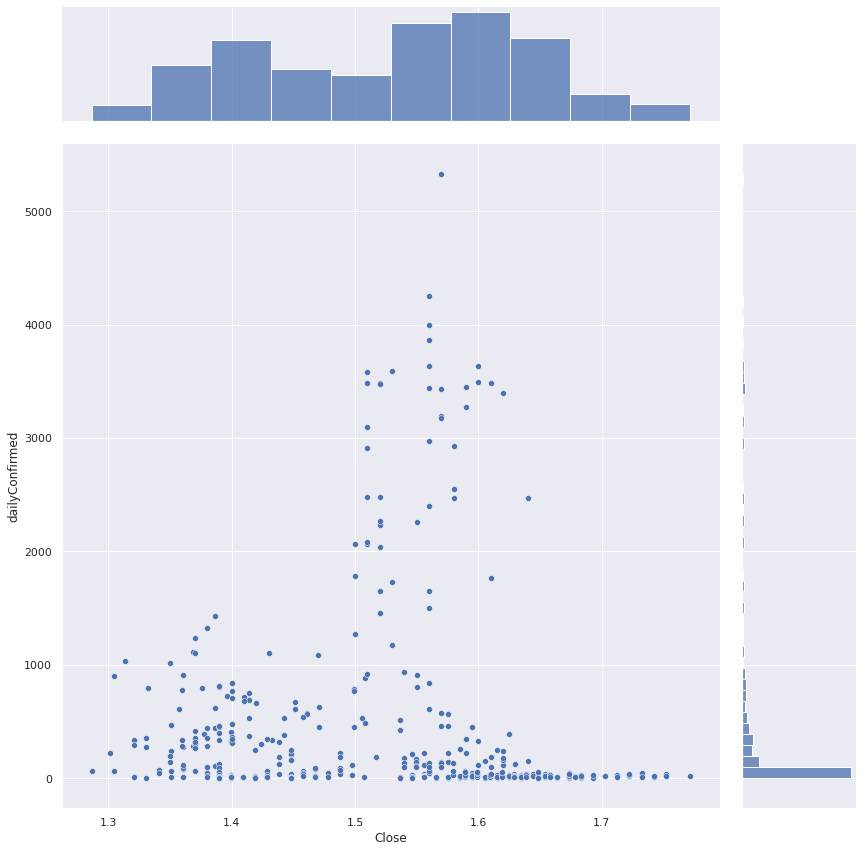

In [ ]:
# Create a joint dataframe by concatenating the two variables
covidcomfortdel = pd.concat([covid, comfortdel_close], axis = 1).reindex(covid.index)

sb.jointplot(data = covidcomfortdel, x = "Close", y = "dailyConfirmed", height = 12)
# covidcomfortdel

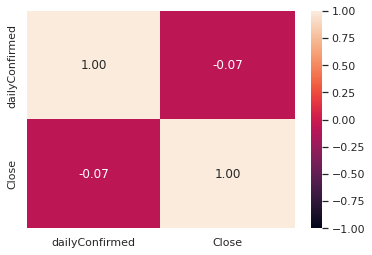

In [ ]:
sb.heatmap(covidcomfortdel.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

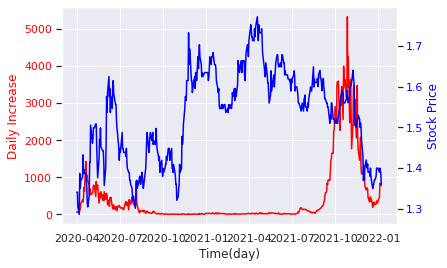

<Figure size 75x75 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Time(day)")
ax1.set_ylabel("Daily Increase", color = 'red')
ax1.plot(covid.Date, covid.dailyConfirmed, color='red')
ax1.tick_params(axis='y', labelcolor = 'red')
ax2 = ax1.twinx()
ax2.set_ylabel("Stock Price", color = 'blue')
ax2.plot(comfortdel_close.Date, comfortdel_close.Close, color='blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.grid(False)
plt.figure(figsize=(0.5,0.5), dpi=150)
plt.show()

Since data for correlation is -0.07, its relation is low. 

### Singtel Telecommunications Limited Inc Daily Close

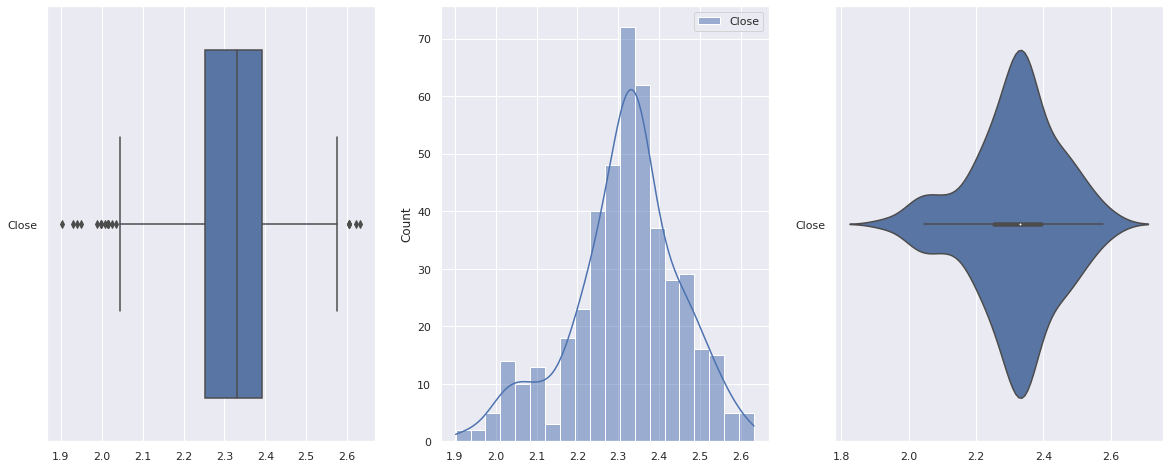

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 8))

sb.boxplot(data = singtel_close, orient = "h", ax = axes[0])
sb.histplot(data = singtel_close, kde= True, ax = axes[1])
sb.violinplot(data = singtel_close, orient = "h", ax = axes[2])

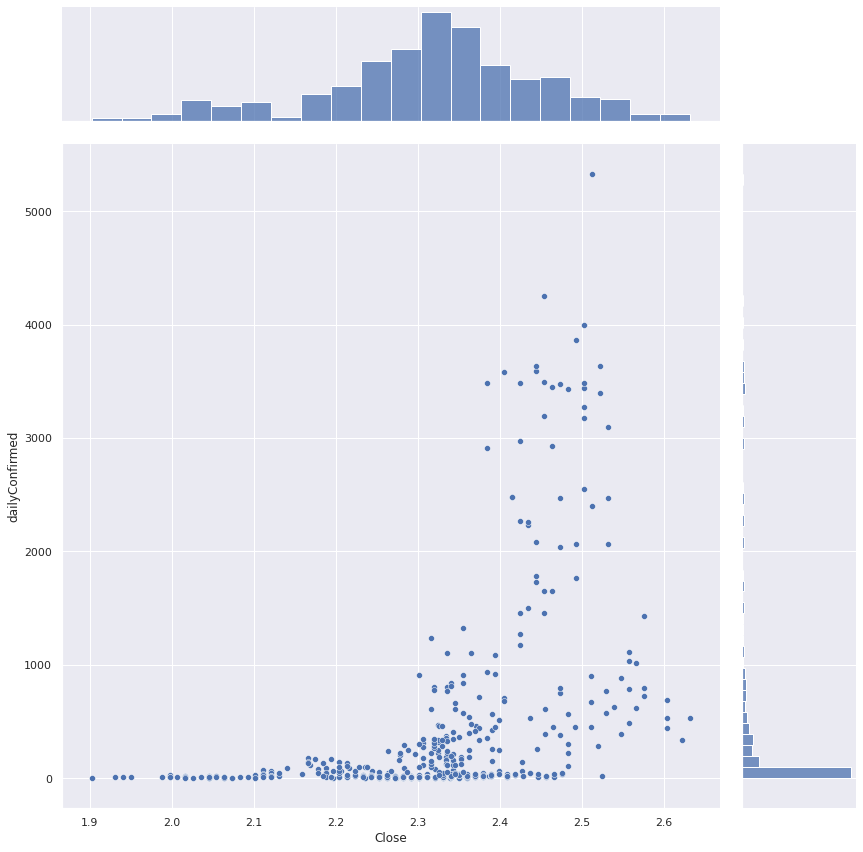

In [ ]:
# Create a joint dataframe by concatenating the two variables
covidsingtel = pd.concat([covid, singtel_close], axis = 1).reindex(covid.index)
sb.jointplot(data = covidsingtel, x = "Close", y = "dailyConfirmed", height = 12)

# covidsingtel

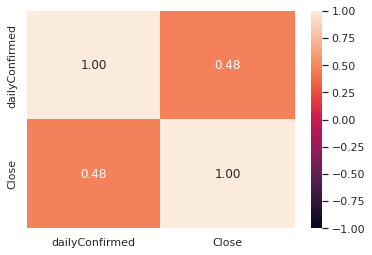

In [ ]:
sb.heatmap(covidsingtel.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

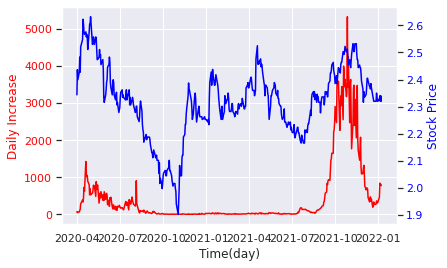

<Figure size 75x75 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Time(day)")
ax1.set_ylabel("Daily Increase", color = 'red')
ax1.plot(covid.Date, covid.dailyConfirmed, color='red')
ax1.tick_params(axis='y', labelcolor = 'red')
ax2 = ax1.twinx()
ax2.set_ylabel("Stock Price", color = 'blue')
ax2.plot(singtel_close.Date, singtel_close.Close, color='blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.grid(False)
plt.figure(figsize=(0.5,0.5), dpi=150)
plt.show()

 Since data for correlation is 0.48, its a moderate low relation.

### Creative Technologies Inc Daily Close

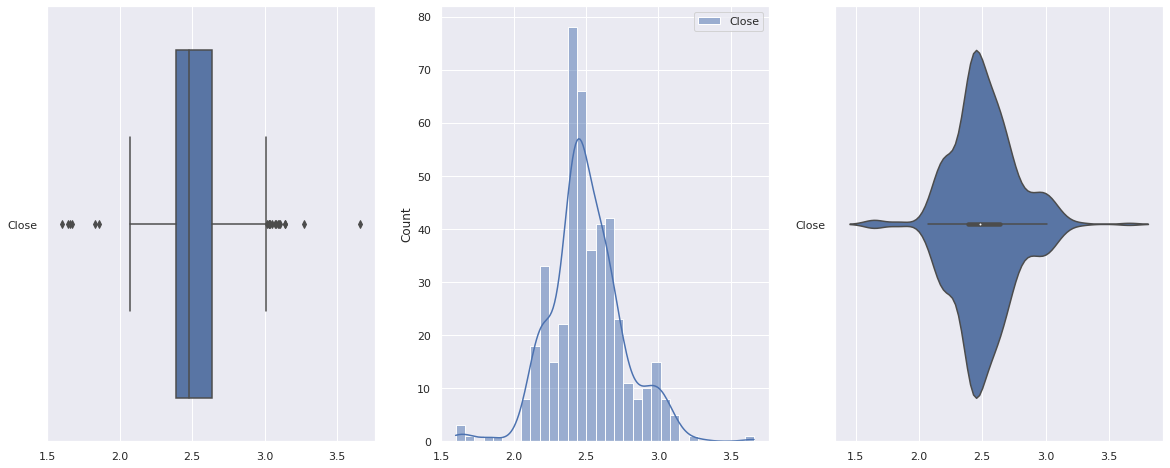

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 8))

sb.boxplot(data = creative_close, orient = "h", ax = axes[0])
sb.histplot(data = creative_close, kde= True, ax = axes[1])
sb.violinplot(data = creative_close, orient = "h", ax = axes[2])

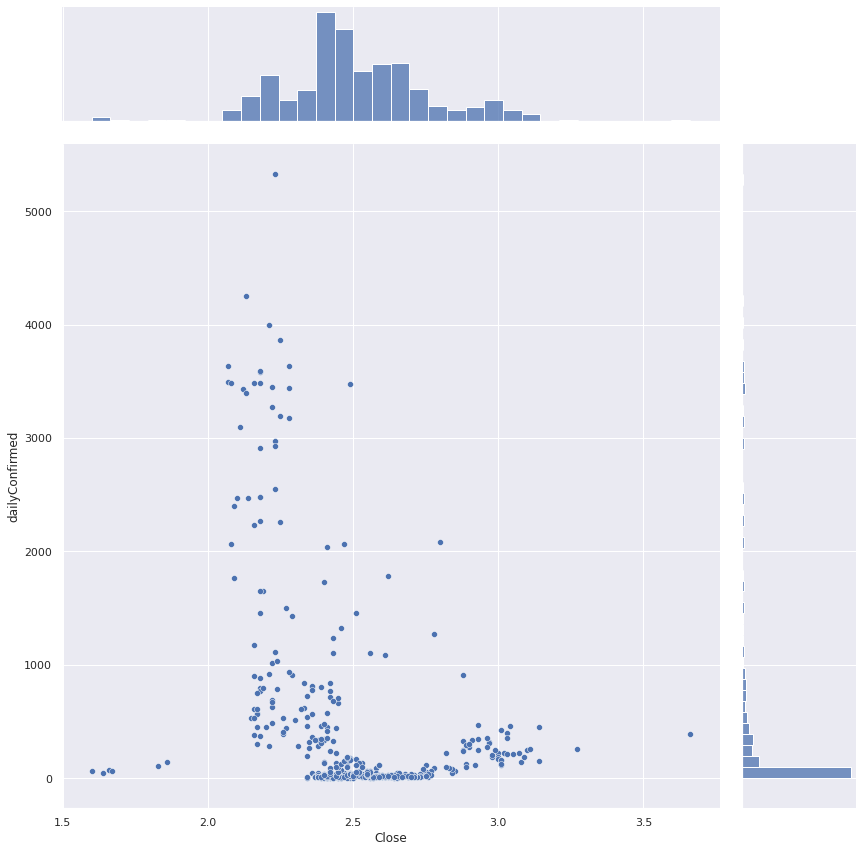

In [ ]:
# Create a joint dataframe by concatenating the two variables
covidcreative = pd.concat([covid, creative_close], axis = 1).reindex(covid.index)
sb.jointplot(data = covidcreative, x = "Close", y = "dailyConfirmed", height = 12)

# covidcreative

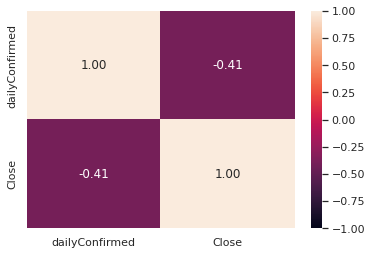

In [ ]:
sb.heatmap(covidcreative.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

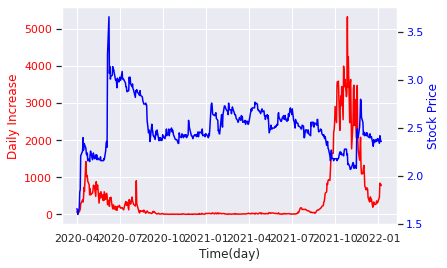

<Figure size 75x75 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Time(day)")
ax1.set_ylabel("Daily Increase", color = 'red')
ax1.plot(covid.Date, covid.dailyConfirmed, color='red')
ax1.tick_params(axis='y', labelcolor = 'red')
ax2 = ax1.twinx()
ax2.set_ylabel("Stock Price", color = 'blue')
ax2.plot(creative_close.Date, creative_close.Close, color='blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.grid(False)
plt.figure(figsize=(0.5,0.5), dpi=150)
plt.show()

Since data for correlation is -0.41, its moderately low relation. 

### Overall Stock Market in Singapore (STI)

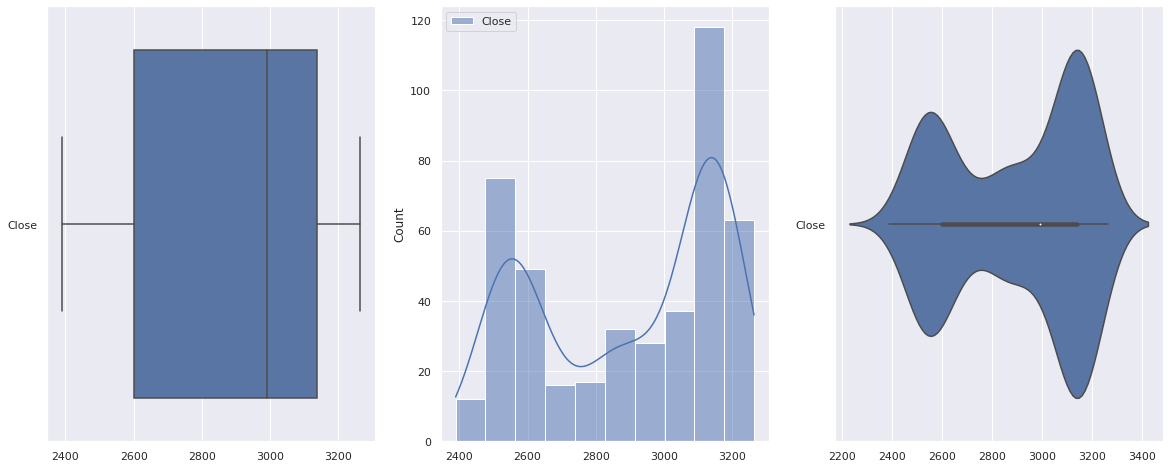

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(20, 8))

sb.boxplot(data = sti_close, orient = "h", ax = axes[0])
sb.histplot(data = sti_close, kde= True, ax = axes[1])
sb.violinplot(data = sti_close, orient = "h", ax = axes[2])

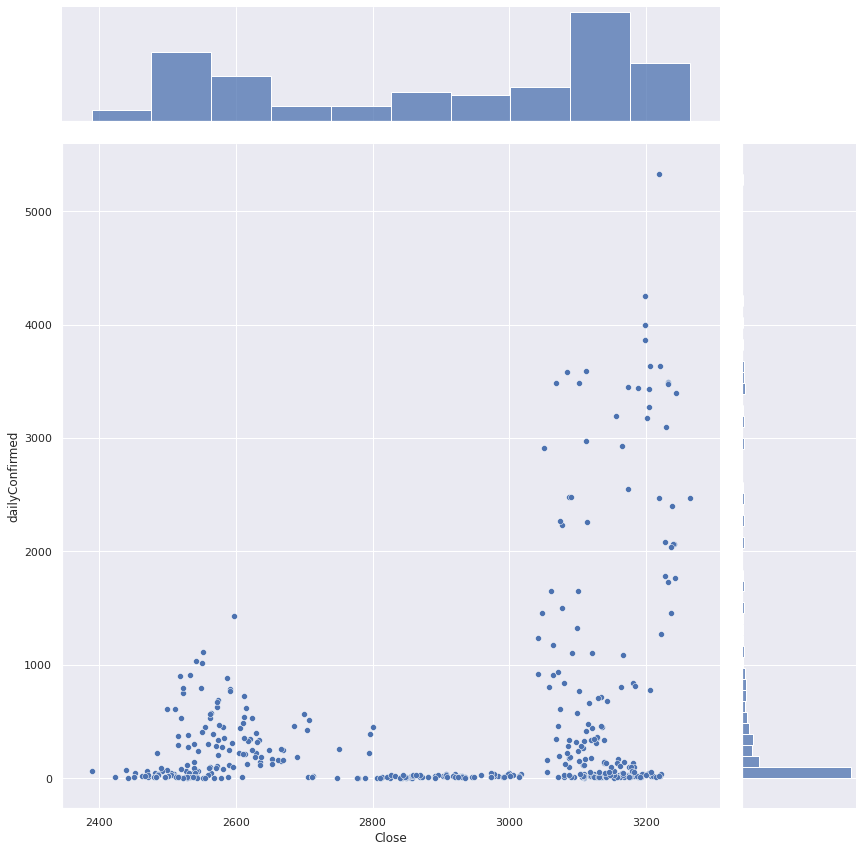

In [ ]:
# Create a joint dataframe by concatenating the two variables
covidsti = pd.concat([covid, sti_close], axis = 1).reindex(covid.index)
sb.jointplot(data = covidsti, x = "Close", y = "dailyConfirmed", height = 12)

# covidsti

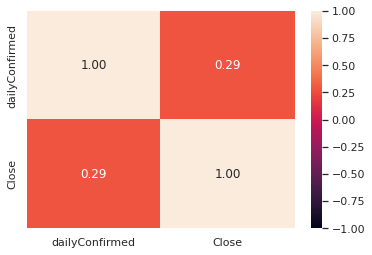

In [ ]:
sb.heatmap(covidsti.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

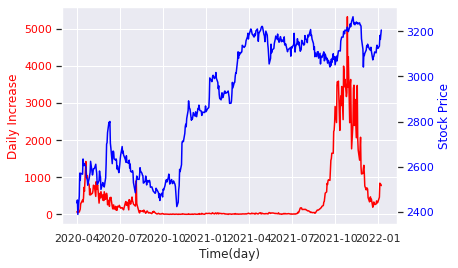

<Figure size 75x75 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Time(day)")
ax1.set_ylabel("Daily Increase", color = 'red')
ax1.plot(covid.Date, covid.dailyConfirmed, color='red')
ax1.tick_params(axis='y', labelcolor = 'red')
ax2 = ax1.twinx()
ax2.set_ylabel("Stock Price", color = 'blue')
ax2.plot(sti_close.Date, sti_close.Close, color='blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.grid(False)
plt.figure(figsize=(0.5,0.5), dpi=150)
plt.show()

Since data for correlation is 0.29, its moderately low relation. 

#Through our analysis, we have concluded that we need to use the boxplot, normal distribution bar graph and violin curve to prepare and clean our data.The heat map and correlation values tells us what to expect for the machine learning data as shown below.

---
## Machine Learning

In [ ]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Singapore Airlines Machine Learning

Intercept of Regression 	: b =  [4.67990974]
Coefficients of Regression 	: a =  [[0.00020356]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.13343111289035592
Mean Squared Error (MSE) 	: 0.2789654755774461

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -8.084897585900393
Mean Squared Error (MSE) 	: 0.8724860896100114



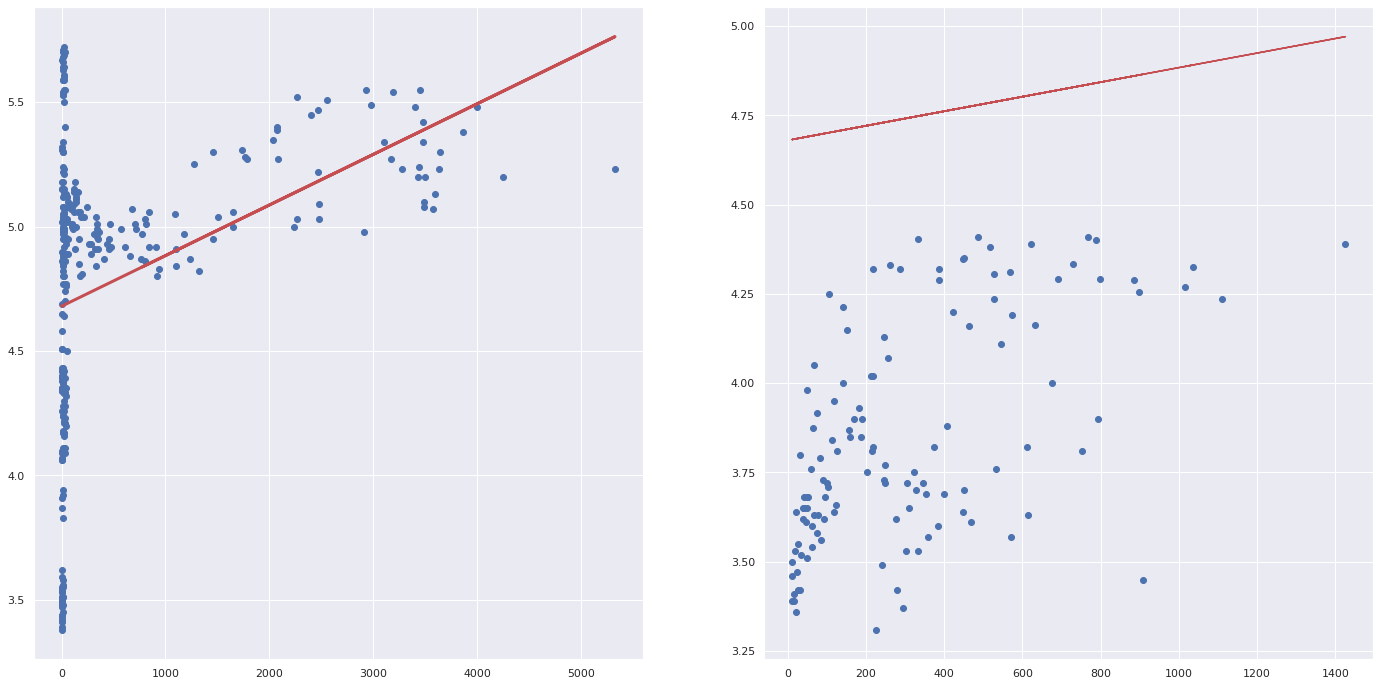

In [ ]:
covid_ml = pd.DataFrame(covid["dailyConfirmed"])
sia_ml = pd.DataFrame(sia_close["Close"])

# Split the Dataset into Train and Test, 75% 25% respectively
X_train = covid_ml.iloc[124:495,:]
X_test = covid_ml.iloc[:124,:]
y_train = sia_ml.iloc[124:495,:]
y_test = sia_ml.iloc[:124,:]


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))

regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train
axes[0].scatter(X_train, y_train)
axes[0].plot(regline_x, y_train_pred, 'r-', linewidth = 3)

axes[1].scatter(X_test, y_test)
axes[1].plot(X_test, y_test_pred, 'r-')

plt.show()

### Biolidics Machine Learning

Intercept of Regression 	: b =  [0.27271912]
Coefficients of Regression 	: a =  [[-3.07307487e-05]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.29120234740589357
Mean Squared Error (MSE) 	: 0.002382718994502984

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -3.2972755638829403
Mean Squared Error (MSE) 	: 0.0203165044649093



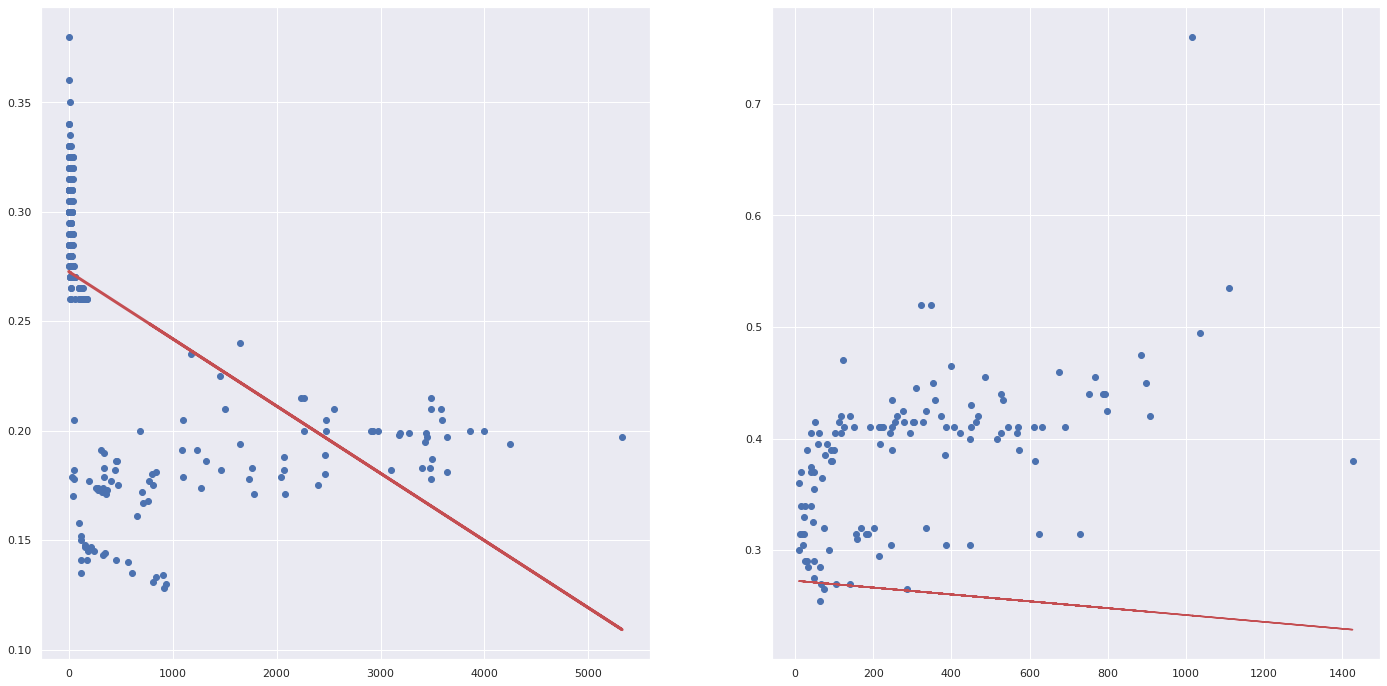

In [ ]:
biolidics_ml = pd.DataFrame(biolidics_close["Close"])

# Split the Dataset into Train and Test
y_train = biolidics_ml.iloc[124:495,:]
y_test = biolidics_ml.iloc[:124,:]
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train
axes[0].scatter(X_train, y_train)
axes[0].plot(regline_x, regline_y, 'r-', linewidth = 3)

axes[1].scatter(X_test, y_test)
axes[1].plot(X_test, y_test_pred, 'r-')

plt.show()

### ComfortDelgro Inc Machine Learning

Intercept of Regression 	: b =  [1.5765151]
Coefficients of Regression 	: a =  [[-1.52737121e-05]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.02405687026707426
Mean Squared Error (MSE) 	: 0.009810106681506349

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -3.4333957384408995
Mean Squared Error (MSE) 	: 0.024697884014222304



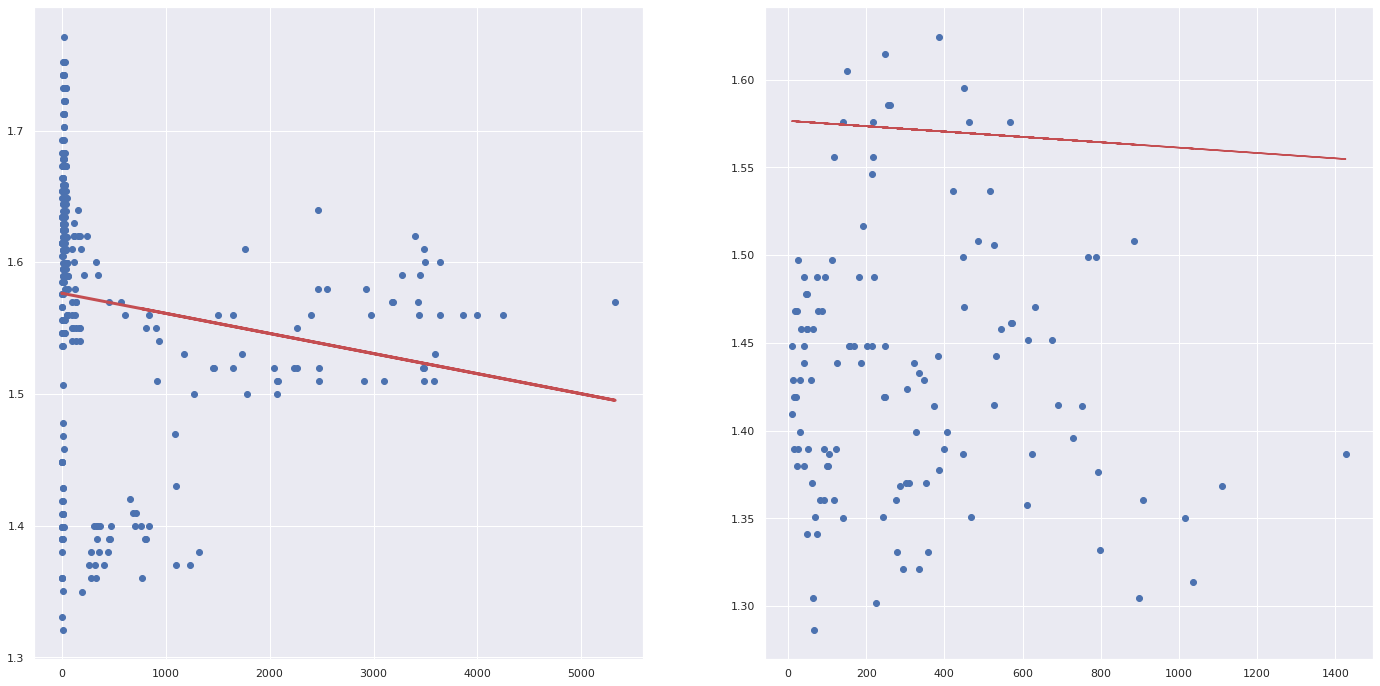

In [ ]:
comfortdel_ml = pd.DataFrame(comfortdel_close["Close"])

# Split the Dataset into Train and Test
y_train = comfortdel_ml.iloc[124:495,:]
y_test = comfortdel_ml.iloc[:124,:]

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))

regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train
axes[0].scatter(X_train, y_train)
axes[0].plot(regline_x, y_train_pred, 'r-', linewidth = 3)

axes[1].scatter(X_test, y_test)
axes[1].plot(X_test, y_test_pred, 'r-')

plt.show()

### Singtel Telecommunications Limited, Inc Machine Learning

Intercept of Regression 	: b =  [2.27733772]
Coefficients of Regression 	: a =  [[6.37674673e-05]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.28799965272674266
Mean Squared Error (MSE) 	: 0.010420432000485336

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.08298959951087137
Mean Squared Error (MSE) 	: 0.02218027939581701



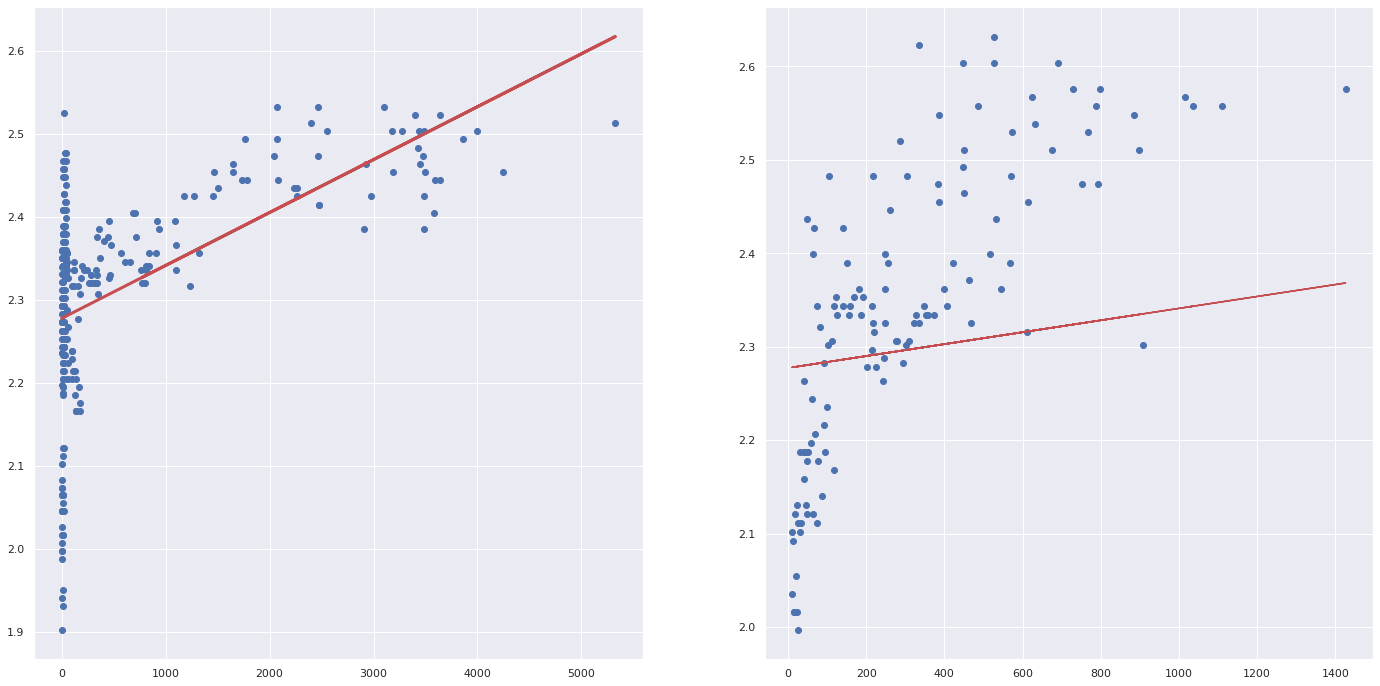

In [ ]:
singtel_ml = pd.DataFrame(singtel_close["Close"])

# Split the Dataset into Train and Test
y_train = singtel_ml.iloc[124:495,:]
y_test = singtel_ml.iloc[:124,:]

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train
axes[0].scatter(X_train, y_train)
axes[0].plot(regline_x, regline_y, 'r-', linewidth = 3)

axes[1].scatter(X_test, y_test)
axes[1].plot(X_test, y_test_pred, 'r-')

plt.show()

### Creative Techonologies Inc Machine Learning

Intercept of Regression 	: b =  [2.5337298]
Coefficients of Regression 	: a =  [[-0.00010461]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.4558159113657828
Mean Squared Error (MSE) 	: 0.013542539184535093

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.0052873303796745486
Mean Squared Error (MSE) 	: 0.15708809151618272



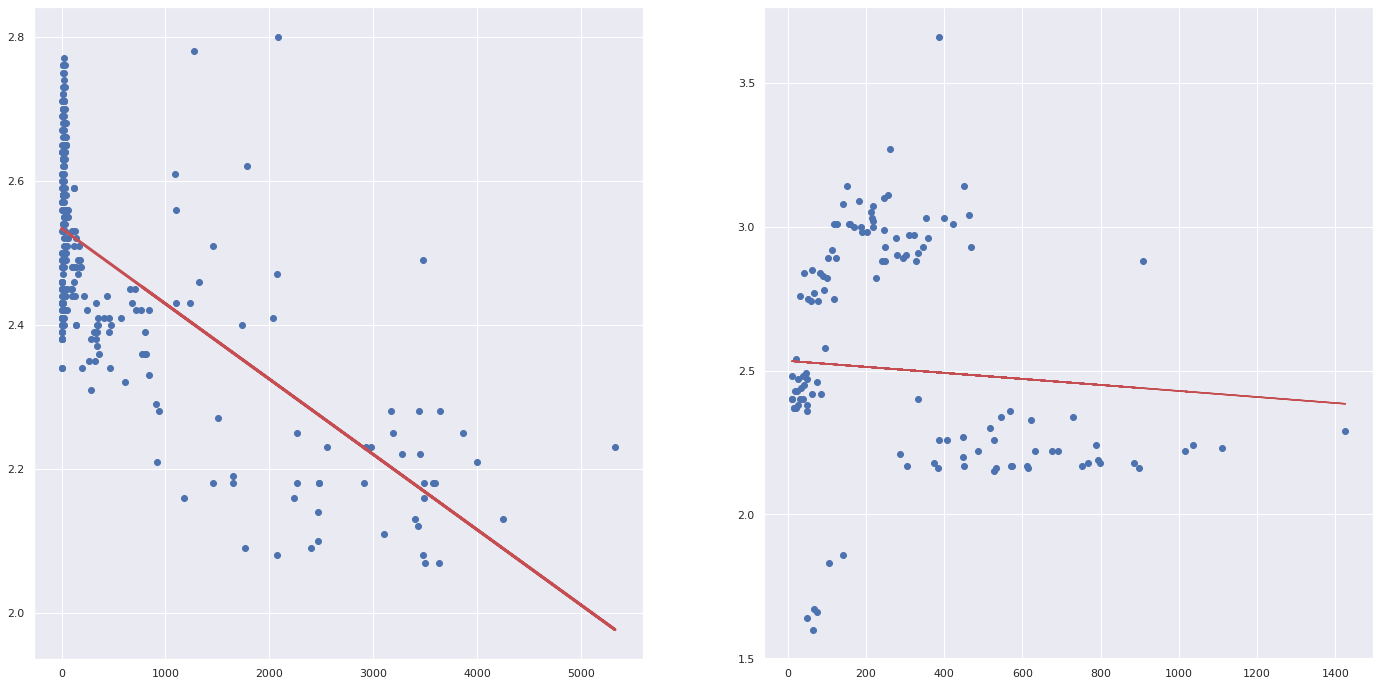

In [ ]:
creative_ml = pd.DataFrame(creative_close["Close"])

# Split the Dataset into Train and Test
y_train = creative_ml.iloc[124:495,:]
y_test = creative_ml.iloc[:124,:]

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train
axes[0].scatter(X_train, y_train)
axes[0].plot(regline_x, regline_y, 'r-', linewidth = 3)

axes[1].scatter(X_test, y_test)
axes[1].plot(X_test, y_test_pred, 'r-')

plt.show()

### LSTM Models

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
df = pd.DataFrame(covidsia[['Close','dailyConfirmed']])
#df = df.iloc[: , 1:]
#df.set_index('Date')

values = df.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')
values[:,1]
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
#print('Y' ,Y.shape)
#print('X' ,X.shape)


#Splitting the dataset
n_train = 124
X_train, X_test = X[n_train:,] , X[:n_train,]
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
#print('Y_train' ,Y_train.shape)
#print('Y_test' ,Y_test.shape)

#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')       

#Train the model
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)



Epoch 1/20
10/10 [==============================] - 5s 7ms/step - loss: 0.3399
Epoch 2/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0937
Epoch 3/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0402
Epoch 4/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0280
Epoch 5/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 6/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0175
Epoch 7/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0161
Epoch 8/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 9/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 10/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 11/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 12/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 13/20
10/10 [=============================

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9238016981018848
Mean Squared Error (MSE) 	: 0.004000002

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.527318217245061
Mean Squared Error (MSE) 	: 0.008094616



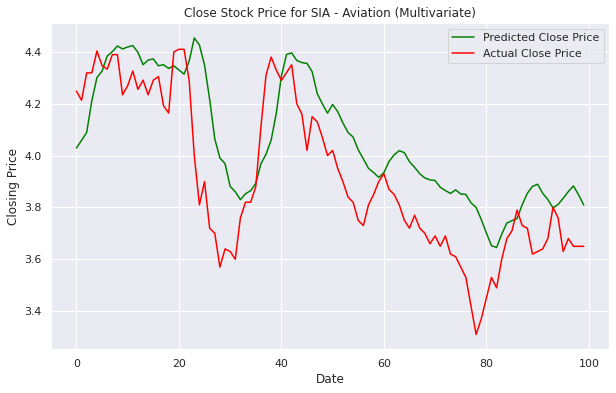

In [ ]:
Y_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

rmse = np.sqrt(mse)
rmse

#Y_predicted = scaler.inverse_transform(Y_pred)
#print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)
#print('scaled Values shape', scaled_dataset.shape)


#Scaling back to the original scale
d = scaled_dataset[:124,:]
#print('dummy',d.shape)
#print('Y_pred',Y_pred.shape)
Y_predicted = np.concatenate((Y_pred,d[:124,1:]), axis =1)
#print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((Y_test, d[:124,1:]), axis = 1)
#print('concat Y_test', Y_test.shape)

Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
#print('Y_tested', Y_tested.shape)
#print('Y_predicted', Y_predicted.shape)


from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_train, Y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_train, Y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_test, Y_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_test, Y_pred))
print()
#Y_predicted = Y_predicted[:,0:1]
#Y_tested = Y_tested[:,0:1]

plt.figure(figsize=(10,6))  
plt.plot(Y_predicted[:100,:], color= 'green',label = 'Predicted Close Price')
plt.plot(Y_tested[:100,:] , color = 'red',label = 'Actual Close Price')
plt.title("Close Stock Price for SIA - Aviation (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20
10/10 [==============================] - 4s 7ms/step - loss: 0.0316
Epoch 2/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 3/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 4/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 6/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 7/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 8/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 9/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 10/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 11/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 12/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 13/20
10/10 [==============================

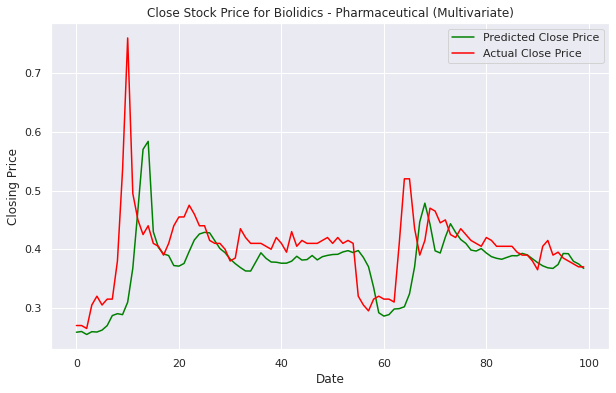

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
df = pd.DataFrame(covidbiolidics[['Close','dailyConfirmed']])
#df = df.iloc[: , 1:]
#df.set_index('Date')

values = df.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')
values[:,1]
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

#Creating a window for previous data
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
#print('Y' ,Y.shape)
#print('X' ,X.shape)

#Splitting the dataset
n_train = 124
X_train, X_test = X[n_train:,] , X[:n_train,]
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
#print('Y_train' ,Y_train.shape)
#print('Y_test' ,Y_test.shape)

#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')       

#Train the model
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Y_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

rmse = np.sqrt(mse)
rmse

#Y_predicted = scaler.inverse_transform(Y_pred)
#print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)
#print('scaled Values shape', scaled_dataset.shape)


#Scaling back to the original scale
d = scaled_dataset[:124,:]
#print('dummy',d.shape)
#print('Y_pred',Y_pred.shape)
Y_predicted = np.concatenate((Y_pred,d[:124,1:]), axis =1)
#print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((Y_test, d[:124,1:]), axis = 1)
#print('concat Y_test', Y_test.shape)

Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
#print('Y_tested', Y_tested.shape)
#print('Y_predicted', Y_predicted.shape)


from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_train, Y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_train, Y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_test, Y_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_test, Y_pred))
print()

#Y_predicted = Y_predicted[:,0:1]
#Y_tested = Y_tested[:,0:1]
# Check the Goodness of Fit (on Train Data)


plt.figure(figsize=(10,6))  
plt.plot(Y_predicted[:100,:], color= 'green',label = 'Predicted Close Price')
plt.plot(Y_tested[:100,:] , color = 'red',label = 'Actual Close Price')
plt.title("Close Stock Price for Biolidics - Pharmaceutical (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20
10/10 [==============================] - 5s 7ms/step - loss: 0.3027
Epoch 2/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0929
Epoch 3/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0397
Epoch 4/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 5/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0167
Epoch 6/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0154
Epoch 7/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0154
Epoch 8/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0137
Epoch 9/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0117
Epoch 10/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 11/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 12/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 13/20
10/10 [==============================

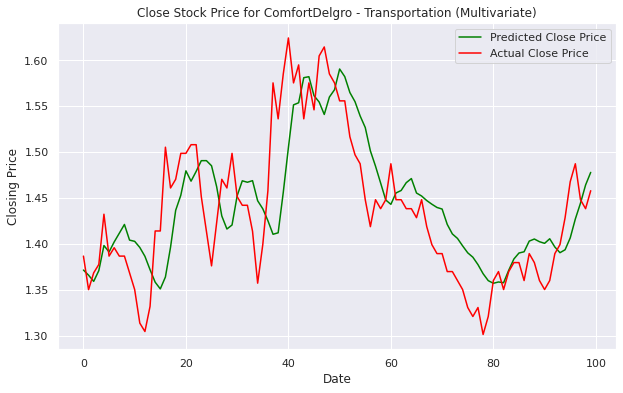

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
df = pd.DataFrame(covidcomfortdel[['Close','dailyConfirmed']])
#df = df.iloc[: , 1:]
#df.set_index('Date')

values = df.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')
values[:,1]
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

#Creating a window for previous data
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
#print('Y' ,Y.shape)
#print('X' ,X.shape)

#Splitting the dataset
n_train = 124
X_train, X_test = X[n_train:,] , X[:n_train,]
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
#print('Y_train' ,Y_train.shape)
#print('Y_test' ,Y_test.shape)

#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')       

#Train the model
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Y_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

rmse = np.sqrt(mse)
rmse

#Y_predicted = scaler.inverse_transform(Y_pred)
#print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)
#print('scaled Values shape', scaled_dataset.shape)


#Scaling back to the original scale
d = scaled_dataset[:124,:]
#print('dummy',d.shape)
#print('Y_pred',Y_pred.shape)
Y_predicted = np.concatenate((Y_pred,d[:124,1:]), axis =1)
#print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((Y_test, d[:124,1:]), axis = 1)
#print('concat Y_test', Y_test.shape)

Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
#print('Y_tested', Y_tested.shape)
#print('Y_predicted', Y_predicted.shape)


from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_train, Y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_train, Y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_test, Y_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_test, Y_pred))
print()

#Y_predicted = Y_predicted[:,0:1]
#Y_tested = Y_tested[:,0:1]
# Check the Goodness of Fit (on Train Data)


plt.figure(figsize=(10,6))  
plt.plot(Y_predicted[:100,:], color= 'green',label = 'Predicted Close Price')
plt.plot(Y_tested[:100,:] , color = 'red',label = 'Actual Close Price')
plt.title("Close Stock Price for ComfortDelgro - Transportation (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20
10/10 [==============================] - 4s 7ms/step - loss: 0.2646
Epoch 2/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0702
Epoch 3/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0297
Epoch 4/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 5/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 6/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 7/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0123
Epoch 8/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 9/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 10/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 11/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 12/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 13/20
10/10 [==============================

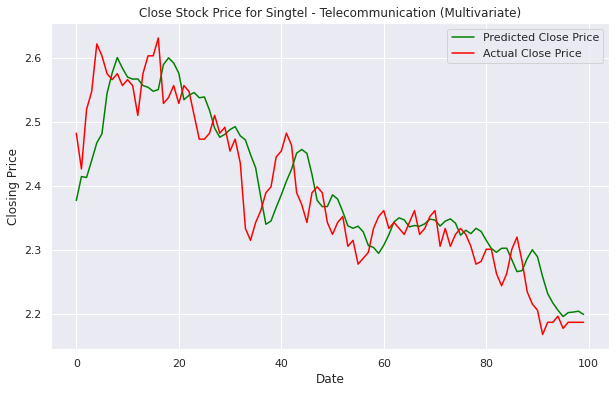

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
df = pd.DataFrame(covidsingtel[['Close','dailyConfirmed']])
#df = df.iloc[: , 1:]
#df.set_index('Date')

values = df.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')
values[:,1]
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

#Creating a window for previous data
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
#print('Y' ,Y.shape)
#print('X' ,X.shape)

#Splitting the dataset
n_train = 124
X_train, X_test = X[n_train:,] , X[:n_train,]
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
#print('Y_train' ,Y_train.shape)
#print('Y_test' ,Y_test.shape)

#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')       

#Train the model
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Y_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

rmse = np.sqrt(mse)
rmse

#Y_predicted = scaler.inverse_transform(Y_pred)
#print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)
#print('scaled Values shape', scaled_dataset.shape)


#Scaling back to the original scale
d = scaled_dataset[:124,:]
#print('dummy',d.shape)
#print('Y_pred',Y_pred.shape)
Y_predicted = np.concatenate((Y_pred,d[:124,1:]), axis =1)
#print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((Y_test, d[:124,1:]), axis = 1)
#print('concat Y_test', Y_test.shape)

Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
#print('Y_tested', Y_tested.shape)
#print('Y_predicted', Y_predicted.shape)


from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_train, Y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_train, Y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_test, Y_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_test, Y_pred))
print()

#Y_predicted = Y_predicted[:,0:1]
#Y_tested = Y_tested[:,0:1]
# Check the Goodness of Fit (on Train Data)


plt.figure(figsize=(10,6))  
plt.plot(Y_predicted[:100,:], color= 'green',label = 'Predicted Close Price')
plt.plot(Y_tested[:100,:] , color = 'red',label = 'Actual Close Price')
plt.title("Close Stock Price for Singtel - Telecommunication (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20
10/10 [==============================] - 4s 7ms/step - loss: 0.1102
Epoch 2/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0255
Epoch 3/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0105
Epoch 4/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 6/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 7/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 8/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 9/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 10/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 11/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 12/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 13/20
10/10 [==============================

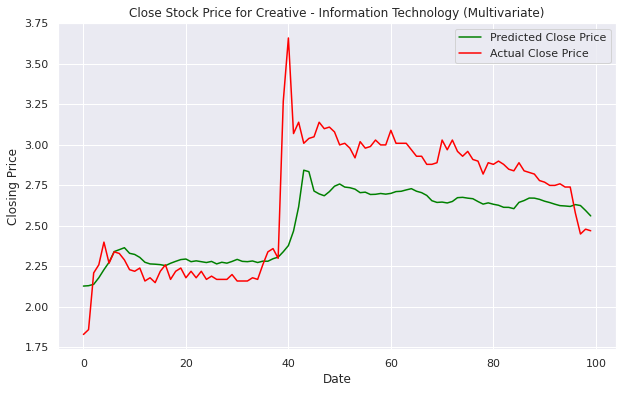

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
df = pd.DataFrame(covidcreative[['Close','dailyConfirmed']])
#df = df.iloc[: , 1:]
#df.set_index('Date')

values = df.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')
values[:,1]
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

#Creating a window for previous data
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
#print('Y' ,Y.shape)
#print('X' ,X.shape)

#Splitting the dataset
n_train = 124
X_train, X_test = X[n_train:,] , X[:n_train,]
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
#print('Y_train' ,Y_train.shape)
#print('Y_test' ,Y_test.shape)

#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')       

#Train the model
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Y_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

rmse = np.sqrt(mse)
rmse

#Y_predicted = scaler.inverse_transform(Y_pred)
#print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
#print('X_test' ,X_test.shape)
#print('scaled Values shape', scaled_dataset.shape)


#Scaling back to the original scale
d = scaled_dataset[:124,:]
#print('dummy',d.shape)
#print('Y_pred',Y_pred.shape)
Y_predicted = np.concatenate((Y_pred,d[:124,1:]), axis =1)
#print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((Y_test, d[:124,1:]), axis = 1)
#print('concat Y_test', Y_test.shape)

Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
#print('Y_tested', Y_tested.shape)
#print('Y_predicted', Y_predicted.shape)


from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_train, Y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_train, Y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(Y_test, Y_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(Y_test, Y_pred))
print()

#Y_predicted = Y_predicted[:,0:1]
#Y_tested = Y_tested[:,0:1]
# Check the Goodness of Fit (on Train Data)


plt.figure(figsize=(10,6))  
plt.plot(Y_predicted[:100,:], color= 'green',label = 'Predicted Close Price')
plt.plot(Y_tested[:100,:] , color = 'red',label = 'Actual Close Price')
plt.title("Close Stock Price for Creative - Information Technology (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

# Conclusion

- None of the stocks selected worked with Covid-19 for the linear regression model since the explained variance is close to zero or negative . The MSE is also too large for test datasets
- Thus, to predict these stocks, we need to consider other facts and think of it as a multivariate problem
- Linear Regression Model might not be optimal for time-series dataset 
- We can also look for other stocks to find a relation between them Covid-19 cases
- Lastly, we can also look for other Machine Learning models like LSTM to predict stock prices as seen previously as it is suitable for time series datasets. 


# Learning Points

- An API allows the user to collect real time data that is updated regularly, depending on the data provider
- How to use API key to retrieve real time data
- How using pd.to_datetime().date() allows appropriate date format to be used
- Understanding the data that we are extracting from eg. Stock Market closes on weekends and holidays, thus we need to remove corresponding data for proper alignment
- Plotting of 2 time series data with different units on the same graph
- Learning new machine learning model like LSTM which uses RNN




# Possible Improvements

- Include covid cases for weekends and holidays
These cases may increase and affect stock prices
- Explore other factors that can cause stocks prices to change
For example, political unrest, improvement of technology, speculation, brand reputation, etc.